## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 62.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=efcb0624122e2052d9e3ba8e9e70307ffc9f565b8f3349721c88c190b1731c1b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 3.1 MB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 

The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

--2022-03-07 23:40:32--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.198.57
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.198.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 23:40:32 (101 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 23:40:32--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.198.57
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.198.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [application/json]
Saving to: ‘us-congress-tweets/tweets-sampl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [6]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [7]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [8]:
# your code here for unique users
tweets.createOrReplaceTempView("tweets_table")

sqlDF = spark.sql("SELECT COUNT (DISTINCT user_id) as unique_users FROM tweets_table")
sqlDF.show()

+------------+
|unique_users|
+------------+
|      198097|
+------------+



b) How many times is the user **GOPLeader** mentioned?


In [9]:
# code here
from pyspark.sql.functions import explode
user_mentions_exploded = tweets.select(explode(tweets.entities.user_mentions).alias('user_mentions_col'))
user_mentions_exploded.where(user_mentions_exploded['user_mentions_col'].screen_name == 'GOPLeader').count()

4761

GOPLeader is mentioned 4761 times

c) Now find the top-5 most mentioned members of Congress.

In [ ]:
# code here
congress_members = spark.read.csv('/content/us-congress-tweets/congress_members.csv', header=True, inferSchema=True)

In [11]:
#join user_mentions_exploded and congress_members based on screen_name using inner join
joined_df = congress_members.join(user_mentions_exploded, congress_members.screen_name == user_mentions_exploded.user_mentions_col.screen_name)
joined_df.groupBy(congress_members.screen_name).count().sort("count", ascending=False).show(5)

+---------------+-----+
|    screen_name|count|
+---------------+-----+
|   senatemajldr|15021|
|LindseyGrahamSC|14412|
|     SenSchumer|13738|
|  RepAdamSchiff|13288|
|     marcorubio| 9957|
+---------------+-----+
only showing top 5 rows



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [12]:
# code here
from pyspark.sql.functions import month, year
df_with_month = tweets.withColumn("month", month("created_at"))
df_with_month = df_with_month.withColumn("year", year("created_at"))
user_mentions_exploded_1 = df_with_month.select(df_with_month['month'], df_with_month['year'], explode(tweets.entities.user_mentions).alias('user_mentions_col'))
for mon in range(10,22):
  mon = mon % 12
  if(mon == 0):
    mon = 12
  temp_df = user_mentions_exploded_1.filter(user_mentions_exploded_1['month'] == mon) 
  year = temp_df.head(1)[0][1]
  temp_df = temp_df.groupBy(temp_df['user_mentions_col'].screen_name).count().sort("count", ascending=False)
  print("Month: %02d / %d" % (mon,year))
  temp_df.show(5)



Month: 10 / 2018
+------------------------------+-----+
|user_mentions_col[screen_name]|count|
+------------------------------+-----+
|                SenatorCollins| 3008|
|                     JeffFlake| 1639|
|               LindseyGrahamSC| 1560|
|               realDonaldTrump| 1500|
|                 lisamurkowski| 1432|
+------------------------------+-----+
only showing top 5 rows

Month: 11 / 2018
+------------------------------+-----+
|user_mentions_col[screen_name]|count|
+------------------------------+-----+
|               realDonaldTrump| 1797|
|                    marcorubio| 1258|
|                   RepSwalwell| 1081|
|                   NancyPelosi| 1035|
|               LindseyGrahamSC| 1004|
+------------------------------+-----+
only showing top 5 rows

Month: 12 / 2018
+------------------------------+-----+
|user_mentions_col[screen_name]|count|
+------------------------------+-----+
|               realDonaldTrump| 1895|
|                   NancyPelosi| 1724|
| 

e) Do you notice anything interesting in your monthly analysis?

Donald Trump features in each month's top 5 most mentioned person. Infact, he is in the top 2 for almost all months. This shows his popularity.

## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [13]:
# your network construction code here
user_mentions_df = spark.read.csv('/content/us-congress-tweets/user_mentions.csv',header=True, inferSchema=True)

In [14]:
user_mentions_df.show(5)

+------------------+----------+-----+
|               src|       dst|count|
+------------------+----------+-----+
|917194889275699201|1249982359|    1|
|917570582555779072| 251918778|    1|
|         633674091| 432895323|   48|
|913222391416934402| 432895323|  261|
|         217574712|  47203904|    1|
+------------------+----------+-----+
only showing top 5 rows



In [16]:
from graphframes import GraphFrame
v = user_mentions_df\
     .select("src")\
     .union(user_mentions_df.select("dst"))\
     .distinct()\
     .withColumnRenamed('src', 'id')

g = GraphFrame(v, user_mentions_df)

How many vertices are there in your network? And how many edges?

In [18]:
# your code
print("vertices are: ", g.vertices.count())
print("edges are: ", g.edges.count())

vertices are:  1133350
edges are:  2064872


In [21]:

src_data = user_mentions_df.select('src')
dst_data = user_mentions_df.select('dst')
union_df = src_data.union(dst_data)
print("vertices: {}".format(union_df.distinct().count()))
#print(src_data.count(),dst_data.count(), union_df.count() )

vertices: 1133350


In [22]:
#user_mentions_df.agg({'count': 'sum'}).show()
print("edges: {}".format(user_mentions_df.count()))

edges: 2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [23]:
# your PageRank code here (should be pretty short since you're just calling a function)
result = g.pageRank(resetProbability=0.15, maxIter=1)

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [24]:
# Top 10 accounts 
result.vertices.select("id", "pagerank").sort("pagerank", ascending=False).show(10)

+----------+------------------+
|        id|          pagerank|
+----------+------------------+
|  25073877|15998.354904223614|
|  29442313|11734.227490974552|
|  15764644|10984.346004007826|
| 432895323| 9925.519362961302|
|1249982359| 9737.226538010977|
|  15745368| 9640.727160557688|
|  29501253| 8649.684301812362|
|  17494010| 8506.343513880918|
| 138203134| 7280.151321627236|
|  15808765| 6880.991259525475|
+----------+------------------+
only showing top 10 rows



In [30]:
top10 = (result.vertices.select("id", "pagerank").sort("pagerank", ascending=False))
top10.join(congress_members, congress_members.userid == top10.id, how='left').show(10)

+----------+------------------+----------+---------------+
|        id|          pagerank|    userid|    screen_name|
+----------+------------------+----------+---------------+
|  25073877|15998.354904223614|      null|           null|
|  29442313|11734.227490974552|  29442313|     SenSanders|
|  15764644|10984.346004007826|  15764644|    NancyPelosi|
| 432895323| 9925.519362961302| 432895323|LindseyGrahamSC|
|1249982359| 9737.226538010977|1249982359|   senatemajldr|
|  15745368| 9640.727160557688|  15745368|     marcorubio|
|  29501253| 8649.684301812362|  29501253|  RepAdamSchiff|
|  17494010| 8506.343513880918|  17494010|     SenSchumer|
| 138203134| 7280.151321627236|      null|           null|
|  15808765| 6880.991259525475|  15808765|     CoryBooker|
+----------+------------------+----------+---------------+
only showing top 10 rows



In [41]:
print(user_mentions_exploded.filter("user_mentions_col.id = '25073877'").head(1))
print(user_mentions_exploded.filter("user_mentions_col.id = '138203134'").head(1))

[Row(user_mentions_col=Row(id=25073877, screen_name='realDonaldTrump'))]
[Row(user_mentions_col=Row(id=138203134, screen_name='AOC'))]


What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

**Analysis:**
From above results, it is seen that out of the top 10 ranked users, 8 are congress members. Other two outsiders are Donald Trump and AOC.

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

**Round 0:** Initialize hubs and authorities scores of all nodes to 1.

*Hub values:* A:1    B:1    C:1  D:1  E:1  F:1  G:1  H:1

*Authority values:* A:1  B:1  C:1  D:1  E:1  F:1   G:1  H:1

**Round 1:**

*Hub values:* A:2  B:2  C:2  D:2  E:4  F:0  G:0  H:2

*Authority values:* A:0  B:1  C:2  D:4  E:2  F:1 G:3 H:1

**Round 2:**

*Hub values:* A:5  B:6  C:6  D:4  E:10  F:0  G:0  H:5

*Authority values:* A:0  B:2  C:6  D:10  E:4  F:2 G:8 H:4

**Round 3:**

*Hub values:* A:12  B:14  C:14  D:10  E:28  F:0  G:0  H:14

*Hub values normalized:* A:0.130  B:0.152  C:0.152 D:0.108  E:0.304  F:0.000  G:0.000  H:0.152

*Authority values:* A:0  B:5  C:15  D:27  E:12  F:04  G:19  H:10

*Authority values normalized:* A:0.000  B:0.054    C:0.163  D:0.293  E:0.130  F:0.043  G:0.207  H:0.109

**Round 4:**

*Hub values:* A:32  B:39  C:39  D:23  E:71  F:0  G:0  H:34

*Hub values normalized:* A:0.134  B:0.164  C:0.164 D:0.097  E:0.298  F:0.000  G:0.000  H:0.143

*Authority values:* A:0  B:12  C:42  D:68  E:28  F:10  G:52  H:28

*Authority values normalized:* A:0  B:0.05       C:0.175  D:0.284  E:0.117  F:0.042  G:0.217  H:0.112

## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


3.1.2
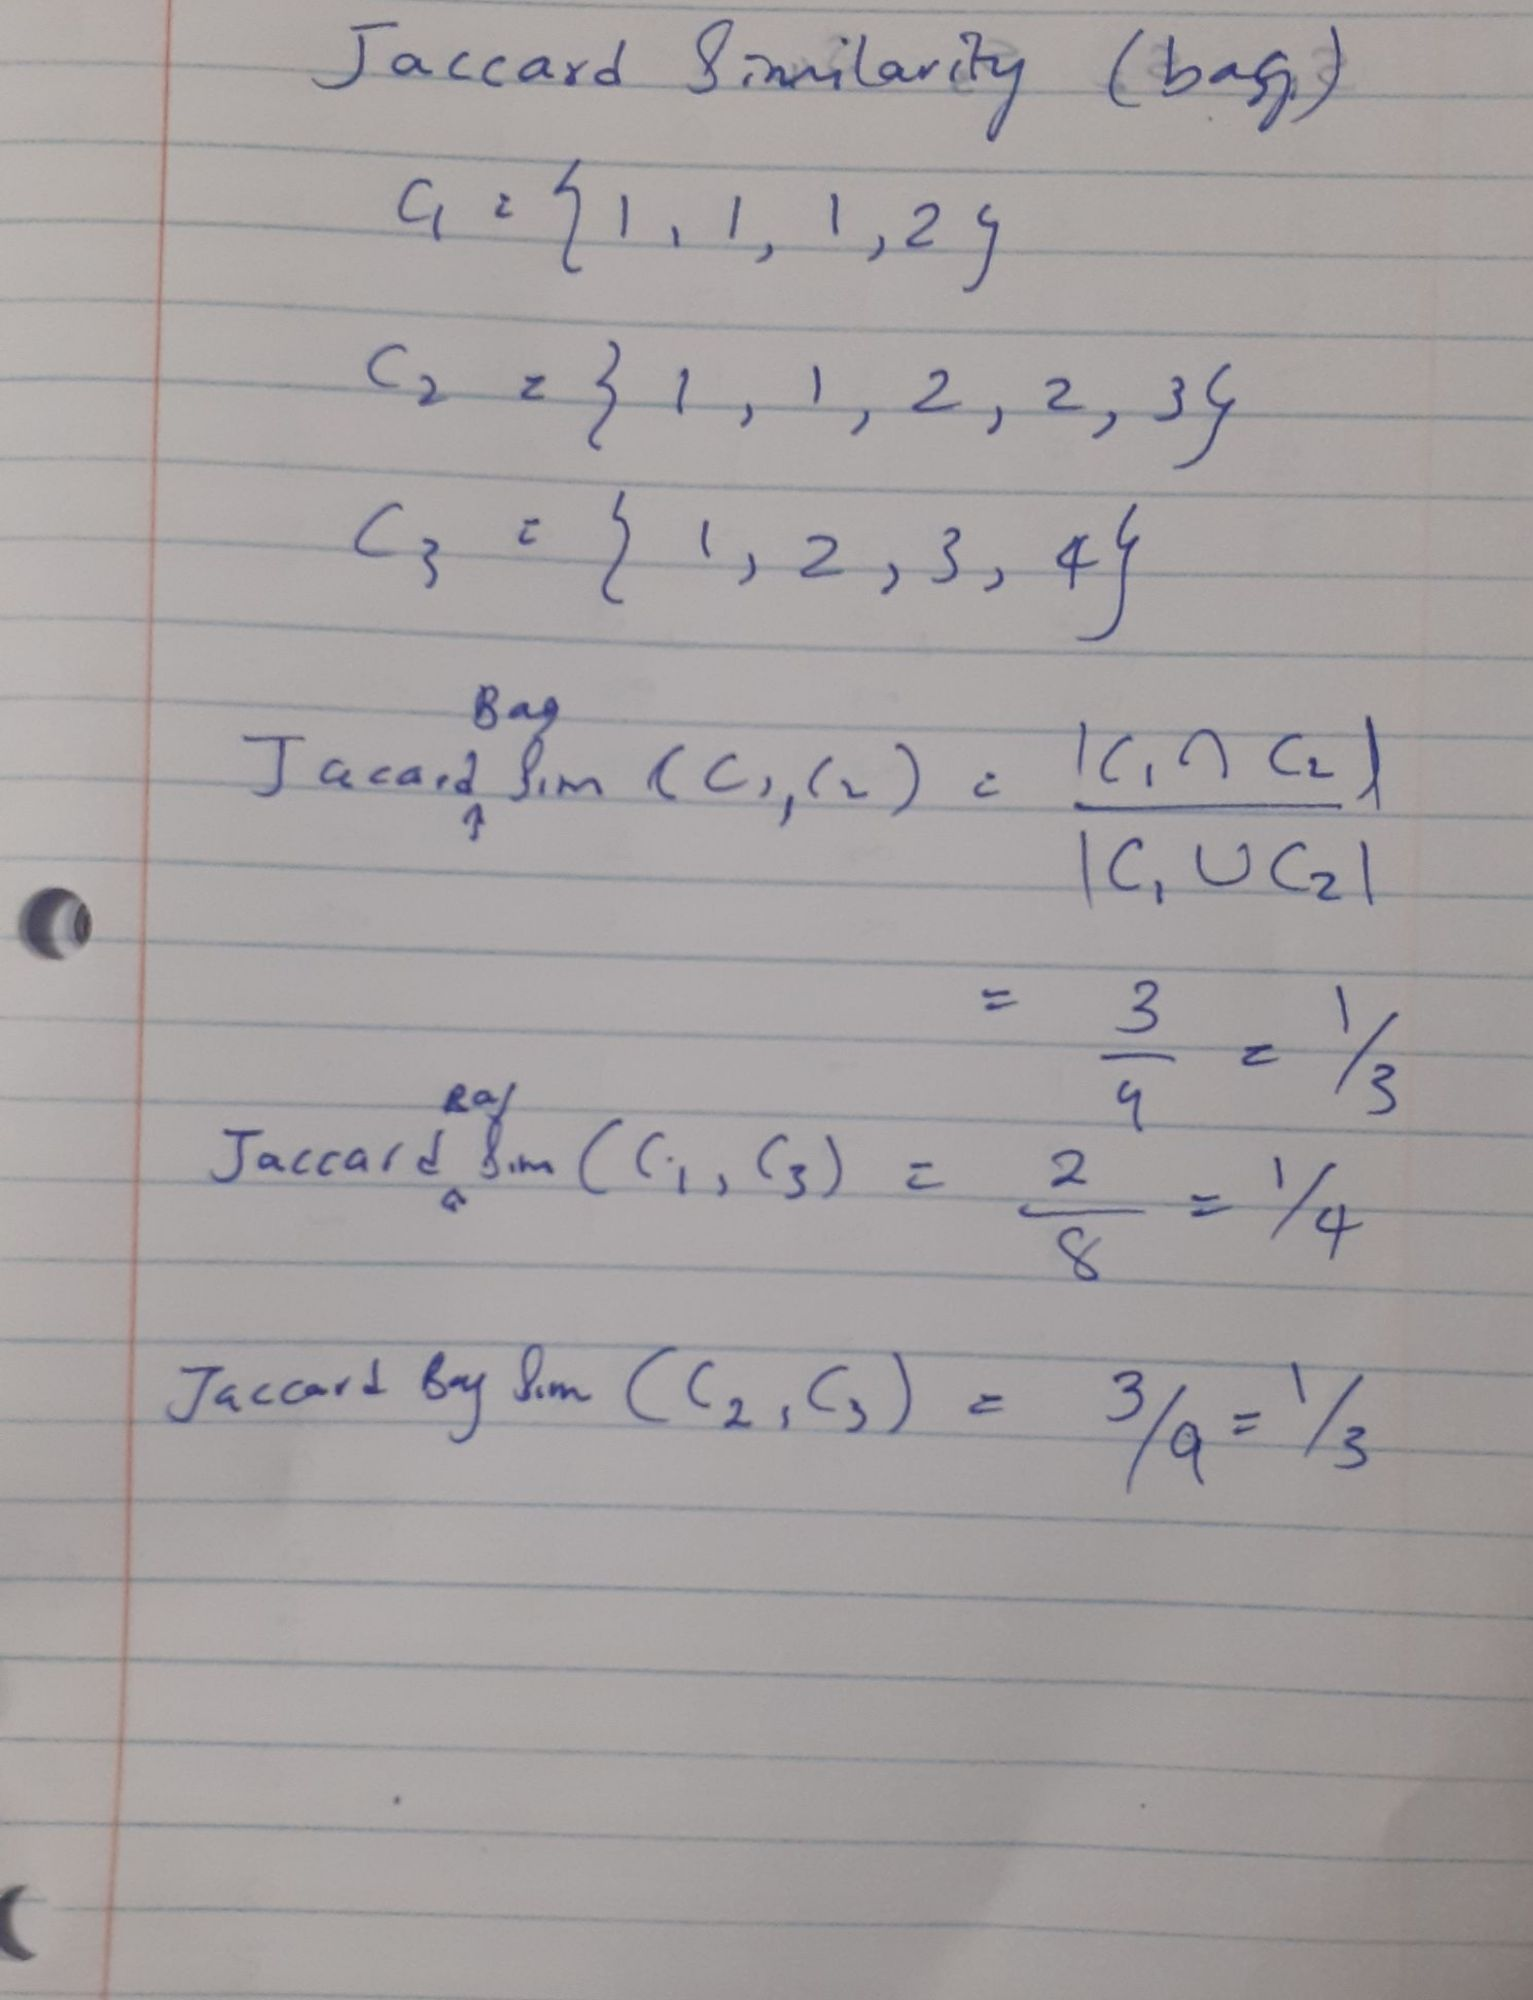

3.2.2

The most effective

way to represent

to represent documents

as sets, for

for the purpose

the purpose of

of identifying lexically

is to construct

to construct from

the document the

the set of

set of short

of short strings

3.3.3

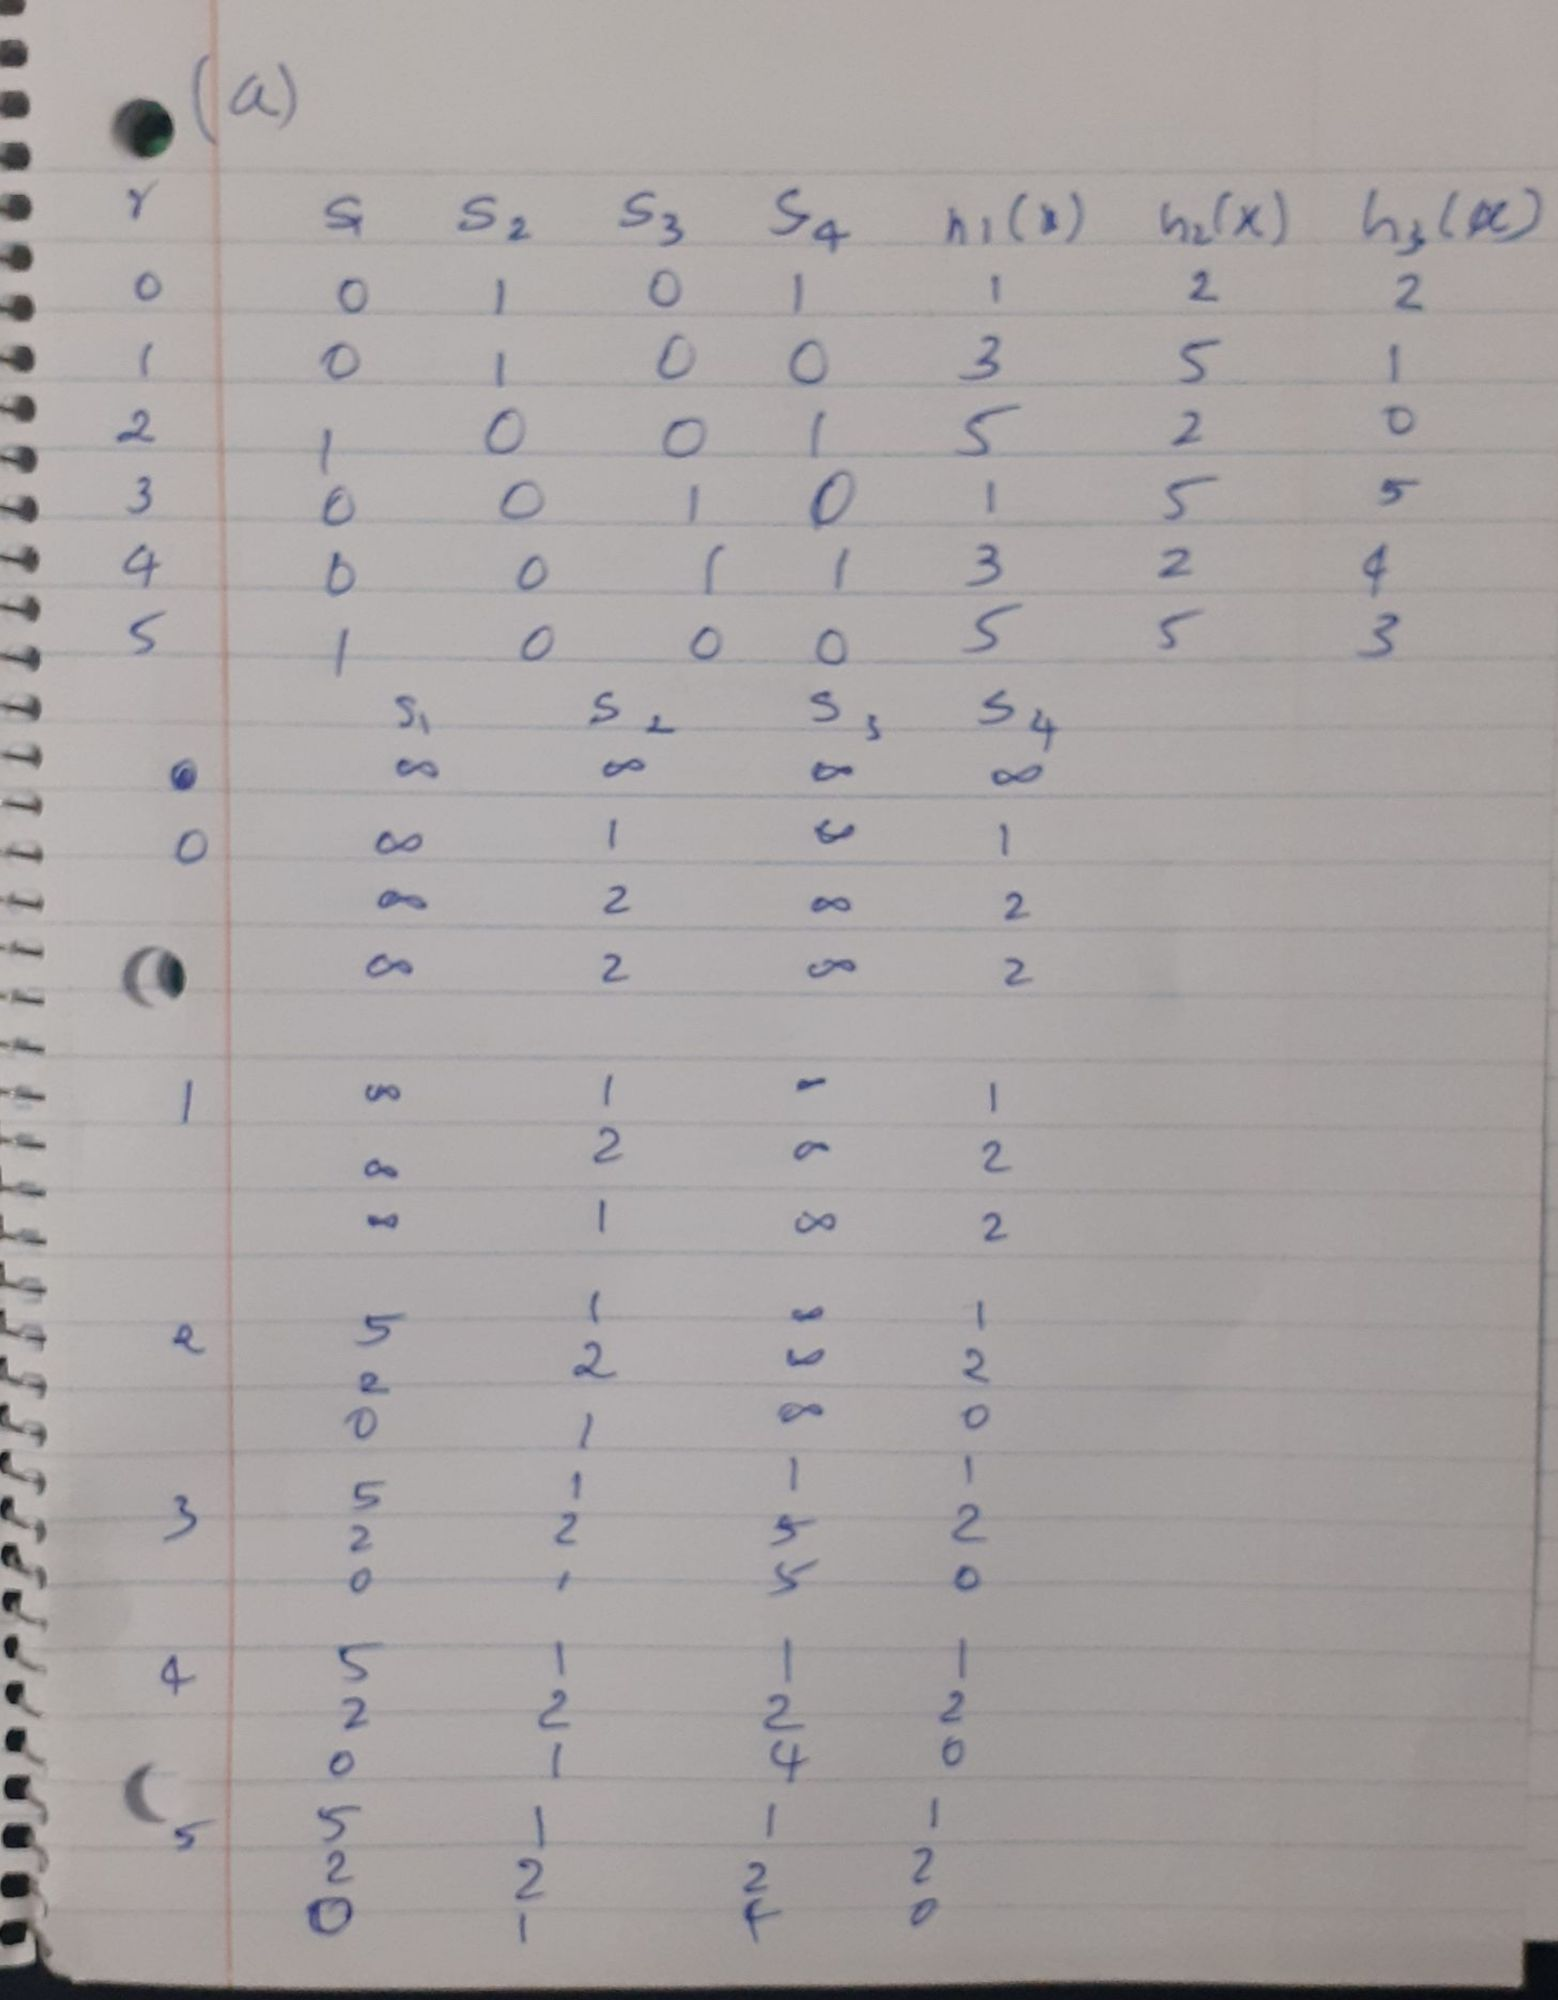

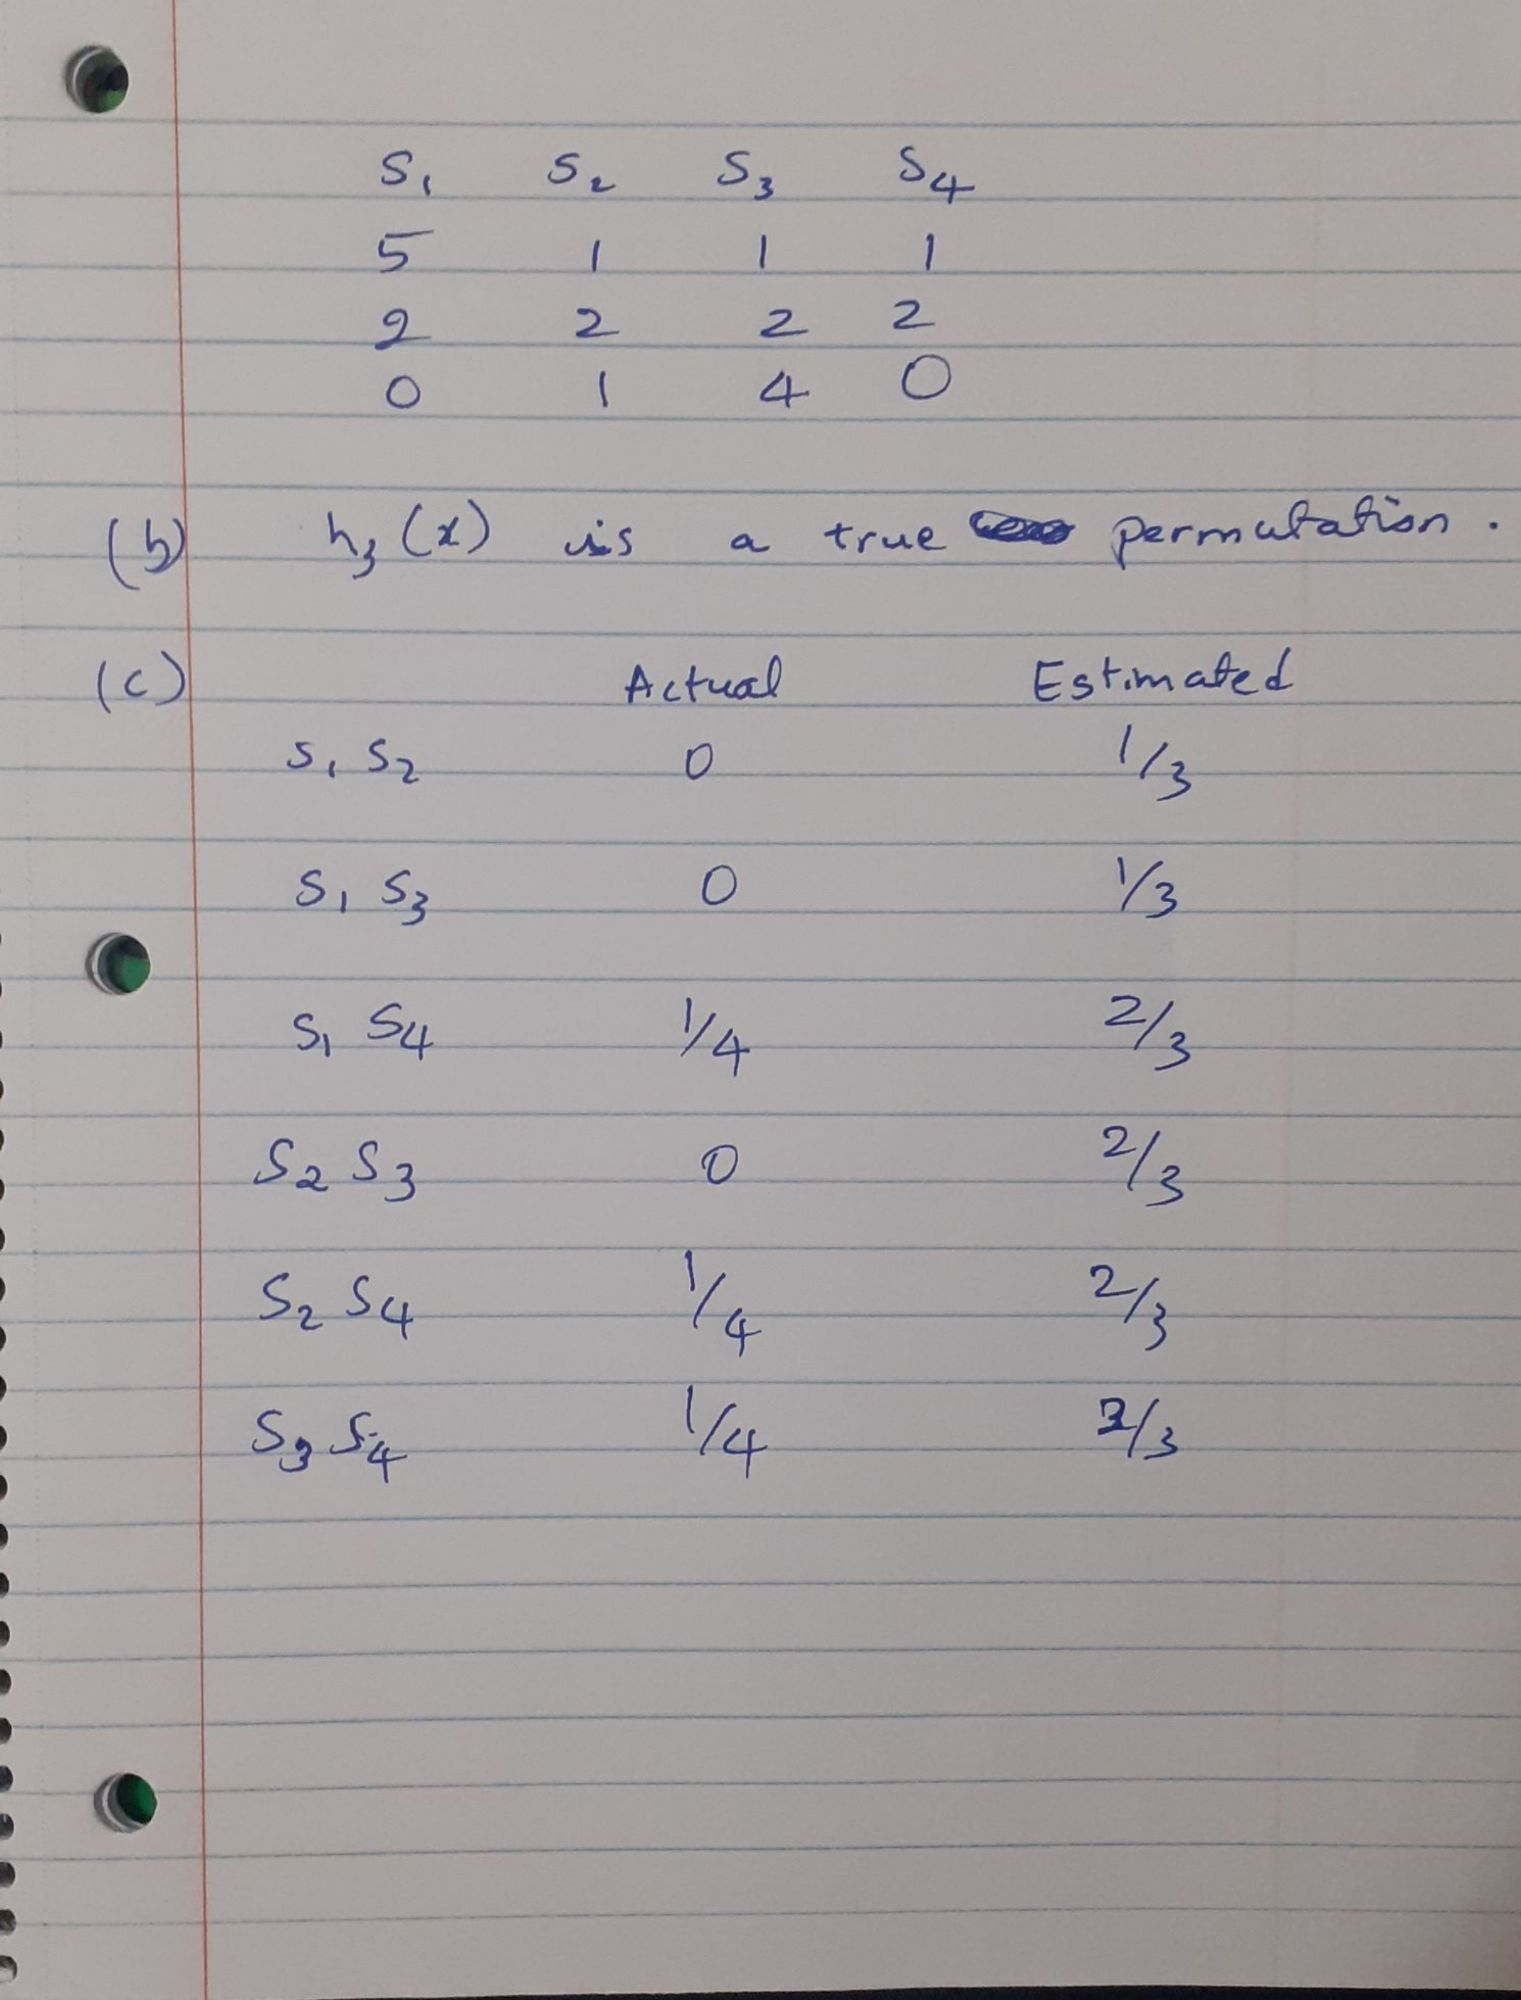

r = 3, b= 10
----------------------------------------------
similarity for s=1/2 from formula = 0.4060881340677083
similarity for s=1/2 estimated = 0.4641588833612779

r = 6, b= 20
----------------------------------------------
similarity for s=1/2 from formula = 0.5693533868256982
similarity for s=1/2 estimated = 0.6069622310029172

r = 5, b= 50
----------------------------------------------
similarity for s=1/2 from formula = 0.4243944803687326
similarity for s=1/2 estimated = 0.45730505192732634



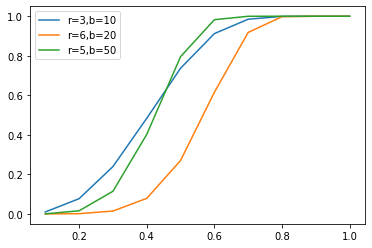

In [12]:
#code for 3.4.1 and 3.4.2

import numpy as np
from math import *
import matplotlib.pyplot as plt

t_list = np.arange(0.1,1.1, 0.1)
r_b_list = [(3,10), (6,20), (5,50)]
prob_list = []
s_half = np.ones(10)*0.5


for i in range(len(r_b_list)):
  prob_list_i = []
  for t in t_list:
    r = r_b_list[i][0]
    b = r_b_list[i][1]
    prob = 1 - pow((1 - pow(t,r)),b)
    prob_list_i.append(prob)
  prob_list.append(prob_list_i)
  s_half_formula = pow((1 - pow(1/2,1/b)), 1/r)
  s_half_estimate = pow(1/b,1/r)
  print("r = {}, b= {}".format(r,b))
  print("----------------------------------------------")
  print("similarity for s=1/2 from formula = {}".format(s_half_formula))
  print("similarity for s=1/2 estimated = {}".format(s_half_estimate))
  print("")

plt.plot(t_list,prob_list[0])
plt.plot(t_list,prob_list[1])
plt.plot(t_list,prob_list[2])
plt.legend(["r=3,b=10","r=6,b=20","r=5,b=50"])



For the above results, we can see that the estimated value and the actual value of similarity for which probability is 1/2 are pretty close to each other.